In [ ]:
!pip install virtualenv

     |████████████████████████████████| 4.9MB 12.3MB/s 
     |████████████████████████████████| 337kB 54.4MB/s 


In [ ]:
!virtualenv Mask-Detection

created virtual environment CPython3.6.9.final.0-64 in 661ms
  creator CPython3Posix(dest=/content/Mask-Detection, clear=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==20.2.4, setuptools==50.3.2, wheel==0.35.1
  activators BashActivator,CShellActivator,FishActivator,PowerShellActivator,PythonActivator,XonshActivator


In [ ]:
!source Mask-Detection//bin/activate

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:
import os
import tensorflow as tf
import keras
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
DIR = r'/gdrive/My Drive/Mask Detection/dataset'
CATEGORIES = ['with-mask', 'without-mask']

for category in CATEGORIES:
  path = os.path.join(DIR, category)
  image_count =  sum([len(files) for r, d, files in os.walk(path)])
  print(f'Number of images in {category} : {image_count}')

Number of images in with-mask : 1000
Number of images in without-mask : 907


In [ ]:
%%time
data = [] 
labels = [] 

for category in CATEGORIES:
  path = os.path.join(DIR, category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size= (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(category)


CPU times: user 3.3 s, sys: 5.59 s, total: 8.89 s
Wall time: 10.2 s


In [ ]:
labels[:5]

['with-mask', 'with-mask', 'with-mask', 'with-mask', 'with-mask']

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels[:5])

[[0]
 [0]
 [0]
 [0]
 [0]]


In [ ]:
labels = to_categorical(labels)
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
data = np.array(data, dtype='float32')
labels = np.array(labels)

In [ ]:
#np.save('/gdrive/My Drive/Mask Detection/data.npy',data)
np.save('/gdrive/My Drive/Mask Detection/labels.npy', data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [ ]:
aug = ImageDataGenerator(rotation_range=10,
                         horizontal_flip = True,
                         shear_range=0.15)

In [ ]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))




In [ ]:
base_model.trainable = False

In [ ]:
top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Flatten(name='flatten')(top_model)
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(64, activation='relu')(top_model)
top_model = Dropout(0.25)(top_model)
top_model = Dense(2, activation='softmax')(top_model)

model = Model(inputs = base_model.input, outputs = top_model)

model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
base_learning_rate = 0.0001
EPOCHS = 20
BS = 64 
model.compile(optimizer=Adam(lr=base_learning_rate, decay= base_learning_rate // EPOCHS),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data = (X_test, y_test),
    epochs=20,
    verbose=1
)

Epoch 1/20
24/24 [==============================] - 15s 634ms/step - loss: 0.6815 - accuracy: 0.6380 - val_loss: 0.6004 - val_accuracy: 0.8455
Epoch 2/20
24/24 [==============================] - 14s 600ms/step - loss: 0.5835 - accuracy: 0.8859 - val_loss: 0.5417 - val_accuracy: 0.9712
Epoch 3/20
24/24 [==============================] - 14s 602ms/step - loss: 0.5472 - accuracy: 0.9456 - val_loss: 0.5218 - val_accuracy: 0.9843
Epoch 4/20
24/24 [==============================] - 14s 598ms/step - loss: 0.5291 - accuracy: 0.9705 - val_loss: 0.5167 - val_accuracy: 0.9869
Epoch 5/20
24/24 [==============================] - 14s 603ms/step - loss: 0.5208 - accuracy: 0.9810 - val_loss: 0.5127 - val_accuracy: 0.9895
Epoch 6/20
24/24 [==============================] - 14s 601ms/step - loss: 0.5196 - accuracy: 0.9803 - val_loss: 0.5114 - val_accuracy: 0.9895
Epoch 7/20
24/24 [==============================] - 14s 601ms/step - loss: 0.5169 - accuracy: 0.9790 - val_loss: 0.5083 - val_accuracy: 0.9974

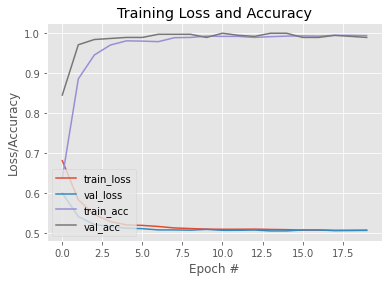

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
model.save("/gdrive/My Drive/Mask Detection/mask_detector.model", save_format="h5")

#things to do


1.   Global Average pooling 

2.   other models

3.   

